In [1]:
import numpy as np
import sys
import os
from astropy.table import Table
import matplotlib.pyplot as plt
sys.path.append('../src')
import parallax

%matplotlib inline

/Library/Python/2.7/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


In [3]:
dtype = [('P_posterior','f8'), ('theta','f8'),
         ('source_id_1','<i8'), ('TYC_id_1','S11'), ('hip_id_1','<i8'),
         ('ra_1','f8'), ('dec_1','f8'),
         ('mu_ra_1','f8'), ('mu_dec_1','f8'), ('mu_ra_err_1','f8'), ('mu_dec_err_1','f8'),
         ('plx_1','f8'), ('plx_err_1','f8'),
         ('gaia_g_flux_1','<f8'), ('gaia_g_flux_err_1','<f8'), ('gaia_g_mag_1','<f8'),
         ('TMASS_id_1','<i8'), ('TMASS_angle_dist_1','<f8'),
#         ('TMASS_n_neighbours_1','<i8'), ('TMASS_n_mates_1','<i8'), ('TMASS_ph_qual_1','S11'),
         ('TMASS_ra_1','<f8'), ('TMASS_dec_1','<f8'),
         ('TMASS_j_mag_1','<f8'), ('TMASS_j_mag_err_1','<f8'),
         ('TMASS_h_mag_1','<f8'), ('TMASS_h_mag_err_1','<f8'),
         ('TMASS_ks_mag_1','<f8'), ('TMASS_ks_mag_err_1','<f8'),
         ('TYC_Vt_1','<f8'), ('TYC_Vt_err_1','<f8'),
         ('TYC_Bt_1','<f8'), ('TYC_Bt_err_1','<f8'),
         ('gaia_delta_Q_1','<f8'), ('gaia_noise_1','<f8'),
         #
         ('source_id_2','<i8'), ('TYC_id_2','S11'), ('hip_id_2','<i8'),
         ('ra_2','f8'), ('dec_2','f8'),
         ('mu_ra_2','f8'), ('mu_dec_2','f8'), ('mu_ra_err_2','f8'), ('mu_dec_err_2','f8'),
         ('plx_2','f8'), ('plx_err_2','f8'),
         ('gaia_g_flux_2','<f8'), ('gaia_g_flux_err_2','<f8'), ('gaia_g_mag_2','<f8'),
         ('TMASS_id_2','<i8'), ('TMASS_angle_dist_2','<f8'),
#         ('TMASS_n_neighbours_2','<i8'), ('TMASS_n_mates_2','<i8'), ('TMASS_ph_qual_2','S11'),
         ('TMASS_ra_2','<f8'), ('TMASS_dec_2','<f8'),
         ('TMASS_j_mag_2','<f8'), ('TMASS_j_mag_err_2','<f8'),
         ('TMASS_h_mag_2','<f8'), ('TMASS_h_mag_err_2','<f8'),
         ('TMASS_ks_mag_2','<f8'), ('TMASS_ks_mag_err_2','<f8'),
         ('TYC_Vt_2','<f8'), ('TYC_Vt_err_2','<f8'),
         ('TYC_Bt_2','<f8'), ('TYC_Bt_err_2','<f8'),
         ('gaia_delta_Q_2','<f8'), ('gaia_noise_2','<f8')
        ]

folder = '../data/TGAS/'

TGAS_empirical = np.genfromtxt(folder+'gaia_wide_binaries_TGAS_plx_empirical.txt', dtype=dtype, names=True)
TGAS_exponential = np.genfromtxt(folder+'gaia_wide_binaries_TGAS_plx_exponential.txt', dtype=dtype, names=True)

In [4]:
dtype = [('source_id_1','<i8'),('source_id_2','<i8'),('P_posterior_1','f8'),('P_posterior_2','f8')]
compare = np.zeros(len(TGAS_empirical), dtype=dtype)
compare_zero = np.zeros(1, dtype=dtype)

compare['source_id_1'] = TGAS_empirical['source_ID_1']
compare['source_id_2'] = TGAS_empirical['source_ID_2']
compare['P_posterior_1'] = TGAS_empirical['P_posterior']



for i in np.arange(len(TGAS_exponential)):
#for i in np.arange(40):
    idx1 = np.where(TGAS_exponential[i]['source_ID_1'] == compare['source_id_1']) 

    if len(idx1[0]) < 1: 
        compare = np.append(compare, compare_zero)
        compare[-1]['source_id_1'] = TGAS_exponential['source_ID_1'][i]
        compare[-1]['source_id_2'] = TGAS_exponential['source_ID_2'][i]
        compare[-1]['P_posterior_2'] = TGAS_exponential['P_posterior'][i]
        continue

    j_good = -1

    for j in idx1[0]:
        if TGAS_exponential[i]['source_ID_2'] == compare[j]['source_id_2']:
            j_good = j

    if j_good == -1:
        compare = np.append(compare, compare_zero)
        compare[-1]['source_id_1'] = TGAS_exponential['source_ID_1'][i]
        compare[-1]['source_id_2'] = TGAS_exponential['source_ID_2'][i]
        compare[-1]['P_posterior_2'] = TGAS_exponential['P_posterior'][i]
    else:
        compare[j_good]['P_posterior_2'] = TGAS_exponential['P_posterior'][i]



In [5]:
# Read in sample from TGAS table
dtype = [('ID','<i8'),('tyc','S11'),('hip','<i8'),('ra','<f8'),('dec','<f8'),('mu_ra','<f8'),('mu_dec','<f8'), \
     ('mu_ra_err','<f8'),('mu_dec_err','<f8'),('plx','<f8'),('plx_err','<f8')]

tgas_full = np.array([], dtype=dtype)

for i in np.arange(1):
    if i < 10:
        filename = ('../data/TGAS/TgasSource_000-000-00' + str(i) + '.csv')
    else:
        filename = ('../data/TGAS/TgasSource_000-000-0' + str(i) + '.csv')

    print filename
    tgas_tmp = Table.read(filename, format='csv', guess=True)
    
    

    tgas = np.zeros(len(tgas_tmp), dtype=dtype)

    tgas['ID'] = tgas_tmp['source_id']
    tgas['tyc'] = tgas_tmp['tycho2_id']
    tgas['hip'] = tgas_tmp['hip']
    tgas['ra'] = tgas_tmp['ra']
    tgas['dec'] = tgas_tmp['dec']
    tgas['mu_ra'] = tgas_tmp['pmra']
    tgas['mu_ra_err'] = tgas_tmp['pmra_error']
    tgas['mu_dec'] = tgas_tmp['pmdec']
    tgas['mu_dec_err'] = tgas_tmp['pmdec_error']
    tgas['plx'] = tgas_tmp['parallax']
    tgas['plx_err'] = tgas_tmp['parallax_error']

    tgas_full = np.append(tgas_full, tgas)

../data/TGAS/TgasSource_000-000-000.csv


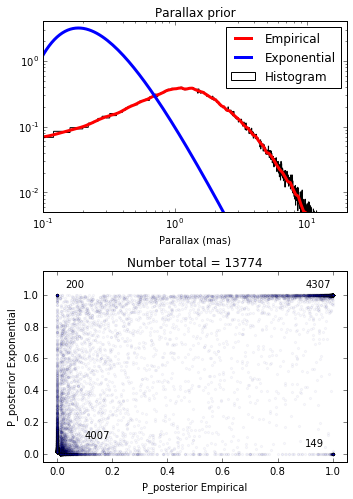

In [7]:
fig, ax = plt.subplots(2, 1, figsize=(5,7))


parallax.plx_kde = None
parallax.set_plx_kde(tgas_full, bandwidth=0.01, method='scipy_kde')


xmin, xmax = 0.01, 100
x = 10**np.linspace(np.log10(xmin), np.log10(xmax), 200)
ax[0].hist(tgas_full['plx'], histtype='step', color='k', bins=10000, normed=True, range=(0,200), label='Histogram')
ax[0].plot(x, parallax.get_plx_prior(x, method='scipy_kde'), color='r', linewidth=3, label='Empirical')
ax[0].plot(x, parallax.get_plx_prior(x, prior='exponential'), color='b', linewidth=3, label='Exponential')
ax[0].set_title('Parallax prior')

ax[0].set_xscale('log')
ax[0].set_xlim(0.1,20)
ax[0].set_yscale('log')
ax[0].set_ylim(5.0e-3, 4.0)
ax[0].set_xlabel('Parallax (mas)')

ax[0].legend()







ax[1].scatter(compare['P_posterior_1'], compare['P_posterior_2'], marker='.', alpha=0.03, rasterized=True)

ax[1].set_xlim(-0.05, 1.05)
ax[1].set_ylim(-0.05, 1.15)

ax[1].set_xlabel('P_posterior Empirical')
ax[1].set_ylabel('P_posterior Exponential')


# Print numbers at bottom right and top left
n_bottom_left = 0
n_bottom_right = 0
n_top_left = 0
n_top_right = 0

for i in np.arange(len(compare)):
    if compare[i]['P_posterior_1'] > 0.9 and compare[i]['P_posterior_2'] > 0.9: n_top_right = n_top_right+1
    if compare[i]['P_posterior_1'] > 0.9 and compare[i]['P_posterior_2'] < 0.1: n_bottom_right = n_bottom_right+1
    if compare[i]['P_posterior_1'] < 0.1 and compare[i]['P_posterior_2'] > 0.9: n_top_left = n_top_left+1
    if compare[i]['P_posterior_1'] < 0.1 and compare[i]['P_posterior_2'] < 0.1: n_bottom_left = n_bottom_left+1

        
ax[1].text(0.9, 0.05, n_bottom_right)
ax[1].text(0.1, 0.1, n_bottom_left)
ax[1].text(0.03, 1.05, n_top_left)
ax[1].text(0.9, 1.05, n_top_right)
        
ax[1].set_title("Number total = " + str(len(compare)))
    
plt.tight_layout()
plt.savefig('../figures/P_posterior_plx_compare.pdf')
#plt.show()